In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterSampler  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import time
import json

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
results = {}

Loading California Housing dataset...
Dataset shape: (20640, 8)

Initializing optimizer...
Starting initial parameter sampling...
Fitting surrogate model...
Starting L-BFGS-B optimization...

Optimization Results:
Best MSE: 0.1900

Best Parameters:
n_estimators: 192
max_depth: 5
min_child_weight: 1
learning_rate: 0.10483060403018869
subsample: 0.7406229768820679
Time taken: 201.22 seconds

Plotting optimization results...


C:\Users\Salwa Khattami\AppData\Local\Temp\ipykernel_24152\2517912280.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(param_names, rotation=45)


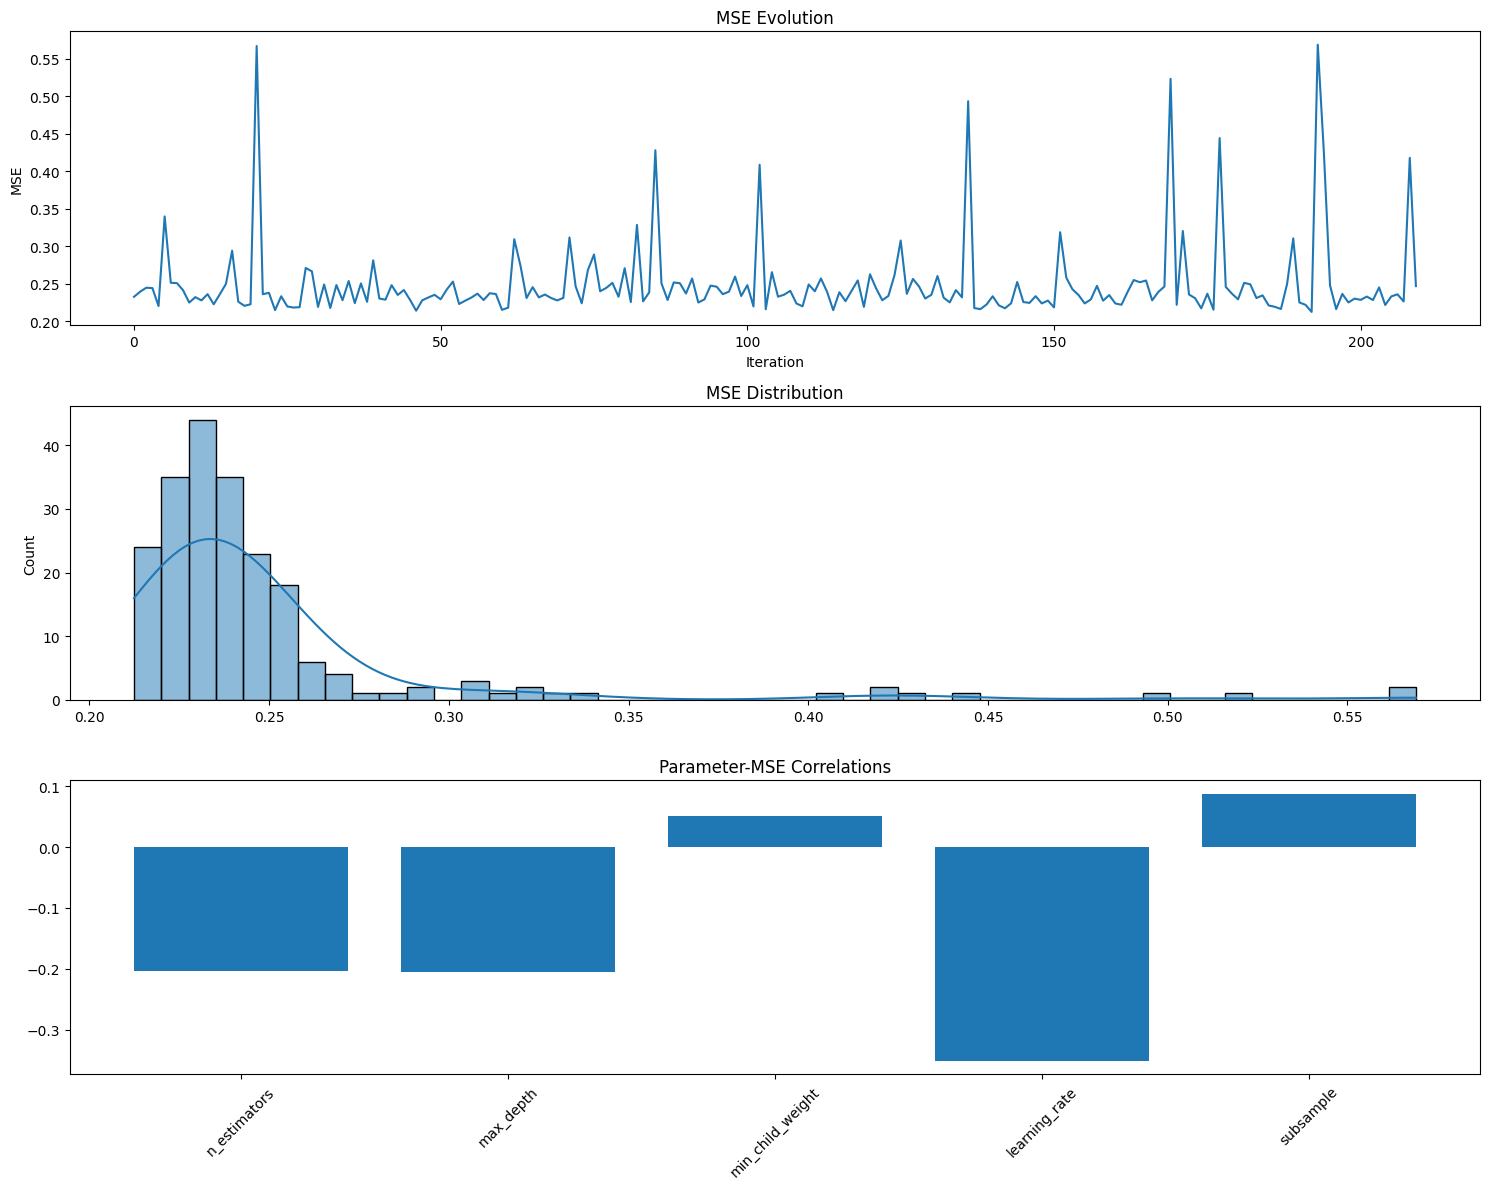

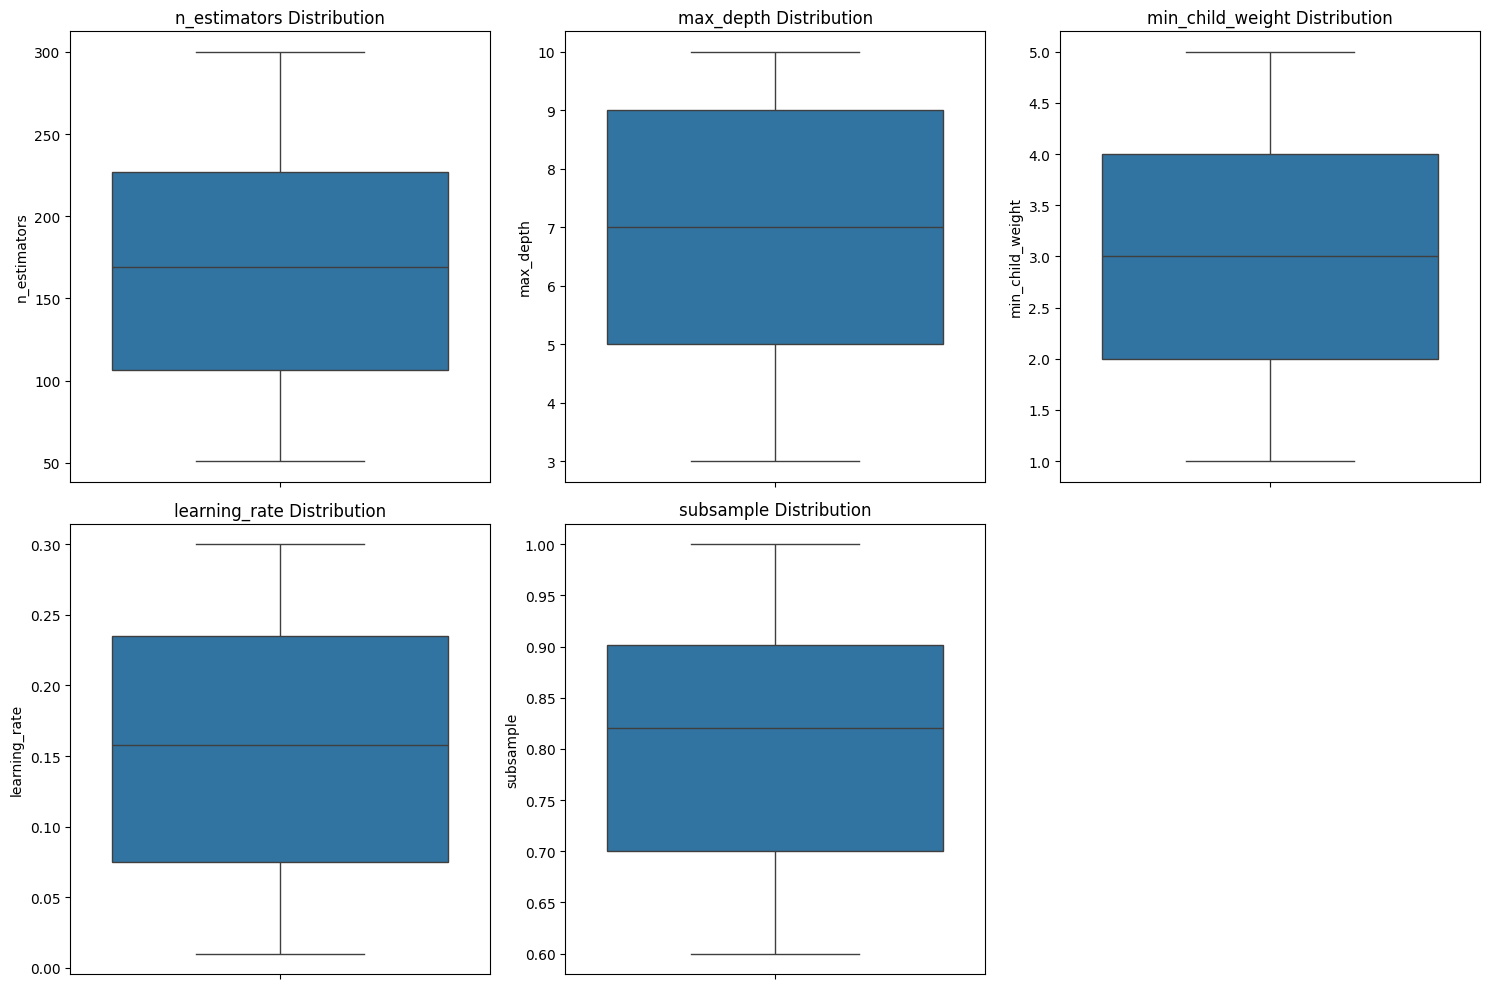

In [3]:
class HyperparameterOptimizer:
    def __init__(self, X, y, test_size=0.2, val_size=0.2, random_state=42):
        """
        Initialize the optimizer with dataset splits and basic parameters.
        """
        # Split data into train, validation, and test sets
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, random_state=random_state
        )
        
        # Initialize optimization parameters
        self.random_state = random_state
        self.surrogate_model = None
        self.best_params = None
        self.best_mse = float('inf')
        self.optimization_history = []
        self.computation_time = 0

    def define_param_space(self):
        """
        Define the hyperparameter search space.
        """
        return {
            'n_estimators': range(50, 301),
            'max_depth': range(3, 11),
            'min_child_weight': range(1, 6),
            'learning_rate': np.linspace(0.01, 0.3, 50),
            'subsample': np.linspace(0.6, 1.0, 50)
        }

    def evaluate_params_parallel(self, params):
        """
        Evaluate a single set of parameters using cross-validation.
        """
        model = XGBRegressor(**params, random_state=self.random_state)
        mse = -cross_val_score(
            model, self.X_train, self.y_train,
            scoring='neg_mean_squared_error', cv=5
        ).mean()
        
        param_values = [
            params['n_estimators'],
            params['max_depth'],
            params['min_child_weight'],
            params['learning_rate'],
            params['subsample']
        ]
        
        return param_values, mse

    def optimize(self, n_samples=210, n_starts=5):
        """
        Main optimization process using Bayesian optimization with L-BFGS-B.
        """
        start_time = time.time()

        print("Starting initial parameter sampling...")
        param_space = self.define_param_space()
        param_sampler = ParameterSampler(
            param_space, n_iter=n_samples, random_state=self.random_state
        )
        # Parallel evaluation of initial samples
        results = Parallel(n_jobs=-1)(
            delayed(self.evaluate_params_parallel)(params)
            for params in param_sampler
        )
        self.optimization_history = [(list(params), mse) for params, mse in results]

        sampled_hyperparams, sampled_mses = zip(*results)
        
        print("Fitting surrogate model...")
        # Create and fit surrogate model
        kernel = C(1.0) * Matern(length_scale=1.0, nu=1.5)
        self.surrogate_model = Pipeline([
            ('scaler', StandardScaler()),
            ('gpr', GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=10,
                random_state=self.random_state
            ))
        ])
        self.surrogate_model.fit(np.array(sampled_hyperparams), np.array(sampled_mses))
        
        print("Starting L-BFGS-B optimization...")
        # Define bounds for L-BFGS-B
        bounds = [(50, 300), (3, 10), (1, 5), (0.01, 0.3), (0.6, 1.0)]
        
        # Multiple optimization runs
        for start in range(n_starts):
            initial_guess = [175, 6, 3, 0.15, 0.8]  # Starting point
            result = minimize(
                lambda x: self.surrogate_model.predict(x.reshape(1, -1))[0],
                x0=initial_guess,
                bounds=bounds,
                method='L-BFGS-B'
            )
        
            if result.fun < self.best_mse:
                self.best_mse = result.fun
                self.best_params = {
                    'n_estimators': int(result.x[0]),
                    'max_depth': int(result.x[1]),
                    'min_child_weight': int(result.x[2]),
                    'learning_rate': result.x[3],
                    'subsample': result.x[4]
                }
        self.computation_time = time.time() - start_time
        return self.best_params, self.best_mse, self.computation_time

    def plot_optimization_results(self):
        """
        Plot optimization history and parameter distributions with improved parameter visualization.
        """
        if not self.optimization_history:
            print("No optimization history available")
            return
            
        # Convert history to arrays
        param_values = np.array([h[0] for h in self.optimization_history])
        mse_values = np.array([h[1] for h in self.optimization_history])
        
        # Create figure with 3 subplots (3x1 layout)
        fig = plt.figure(figsize=(15, 12))
        
        # 1. MSE Evolution (top subplot)
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(mse_values)
        ax1.set_title('MSE Evolution')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('MSE')
        
        # 2. MSE Distribution (middle subplot)
        ax2 = plt.subplot(3, 1, 2)
        sns.histplot(mse_values, ax=ax2, kde=True)
        ax2.set_title('MSE Distribution')
        
        # 3. Parameter Correlations with MSE (bottom subplot)
        ax3 = plt.subplot(3, 1, 3)
        param_names = ['n_estimators', 'max_depth', 'min_child_weight', 
                      'learning_rate', 'subsample']
        correlations = [np.corrcoef(param_values[:, i], mse_values)[0, 1] 
                       for i in range(param_values.shape[1])]
        ax3.bar(param_names, correlations)
        ax3.set_xticklabels(param_names, rotation=45)
        ax3.set_title('Parameter-MSE Correlations')
        
        plt.tight_layout()
        
        # Create a separate figure for parameter distributions
        fig2, param_axes = plt.subplots(2, 3, figsize=(15, 10))
        param_axes = param_axes.ravel()
        
        # Plot each parameter distribution separately
        for i, (name, values) in enumerate(zip(param_names, param_values.T)):
            sns.boxplot(y=values, ax=param_axes[i])
            param_axes[i].set_title(f'{name} Distribution')
            param_axes[i].set_ylabel(name)
        
        # Remove the extra subplot
        param_axes[-1].remove()
        
        plt.tight_layout()
        plt.show()

def run_optimization_example():
    # Load California Housing dataset
    print("Loading California Housing dataset...")
    X, y = fetch_california_housing(return_X_y=True)
    print(f"Dataset shape: {X.shape}")
    
    # Create and run optimizer
    print("\nInitializing optimizer...")
    optimizer = HyperparameterOptimizer(X, y)
    best_params, best_mse, custom_time = optimizer.optimize(n_samples=210) 
    
    # Print results
    print("\nOptimization Results:")
    print(f"Best MSE: {best_mse:.4f}")
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Time taken: {custom_time:.2f} seconds")
    
    # Plot results
    print("\nPlotting optimization results...")
    optimizer.plot_optimization_results()

    results = {}  # Define results dictionary
    results['OR_Optimization'] = {
        'MSE': best_mse,
        'Time': custom_time,
        'Parameters': best_params
    }
    
    return optimizer

if __name__ == "__main__":
    optimizer = run_optimization_example()

In [4]:
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
results = {}

### Methode par defaut: 

In [5]:

start_time = time.time()
default_model = XGBRegressor(random_state=42)
default_model.fit(X_train, y_train)
default_pred = default_model.predict(X_test)
default_mse = mean_squared_error(y_test, default_pred)
default_time = time.time() - start_time
results['Default'] = {
        'mse': default_mse,
        'CT': default_time,
        'params': default_model.get_params()
    }


### Bayesian optimization

In [6]:
# Define parameter space for Bayesian optimization
bayes_param_space = {
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'min_child_weight': (1, 5),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.6, 1.0)
}

# Start timer
start_time = time.time()

# Initialize and run Bayesian optimization
bayes_opt = BayesSearchCV(
    XGBRegressor(random_state=42),
    bayes_param_space,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

bayes_opt.fit(X_train, y_train)

# Make predictions
y_pred_bayes = bayes_opt.predict(X_test)
bayes_mse = mean_squared_error(y_test, y_pred_bayes)
bayes_time = time.time() - start_time

print("Bayesian Optimization Results:")
print(f"Best parameters: {bayes_opt.best_params_}")
print(f"Best MSE: {bayes_mse:.6f}")
print(f"Time taken: {bayes_time:.2f} seconds")

Bayesian Optimization Results:
Best parameters: OrderedDict({'learning_rate': 0.11195781905322144, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8776142126290247})
Best MSE: 0.201321
Time taken: 506.69 seconds


### Grid Search

In [7]:
# Define parameter grid for Grid Search
grid_param_space = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

# Start timer
start_time = time.time()

# Initialize and run Grid Search
grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    grid_param_space,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Make predictions
y_pred_grid = grid_search.predict(X_test)
grid_mse = mean_squared_error(y_test, y_pred_grid)
grid_time = time.time() - start_time

print("Grid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best MSE: {grid_mse:.6f}")
print(f"Time taken: {grid_time:.2f} seconds")

Grid Search Results:
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Best MSE: 0.199140
Time taken: 1009.57 seconds


### Random Search

In [8]:
# Define parameter distributions for Random Search
random_param_space = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 6),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.6, 1.0, 5)
}

# Start timer
start_time = time.time()

# Initialize and run Random Search
random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    random_param_space,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Make predictions
y_pred_random = random_search.predict(X_test)
random_mse = mean_squared_error(y_test, y_pred_random)
random_time = time.time() - start_time

print("Random Search Results:")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best MSE: {random_mse:.6f}")
print(f"Time taken: {random_time:.2f} seconds")

Random Search Results:
Best parameters: {'subsample': np.float64(0.9), 'n_estimators': np.int64(250), 'min_child_weight': np.int64(2), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.13210526315789473)}
Best MSE: 0.203888
Time taken: 83.67 seconds


In [9]:
# Create comparison dictionary
results = {
    'Bayesian Optimization': {
        'MSE': bayes_mse,
        'Time': bayes_time,
        'Parameters': bayes_opt.best_params_
    },
    'Grid Search': {
        'MSE': grid_mse,
        'Time': grid_time,
        'Parameters': grid_search.best_params_
    },
    'Random Search': {
        'MSE': random_mse,
        'Time': random_time,
        'Parameters': random_search.best_params_
    },
    'Default': {
        'MSE': default_mse,
        'Time': default_time,
        'Parameters': default_model.get_params()
    },
    'OR_Optimization': {
        'MSE': optimizer.best_mse,
        'Time': optimizer.computation_time,
        'Parameters': optimizer.best_params
    }
}

# Print comparison
print("Comparison of Methods:")
print("-" * 50)
for method, metrics in results.items():
    print(f"\n{method}:")
    print(f"MSE: {metrics['MSE']:.6f}")
    print(f"Time: {metrics['Time']:.2f} seconds")
    print("Best Parameters:")
    for param, value in metrics['Parameters'].items():
        print(f"  {param}: {value}")

Comparison of Methods:
--------------------------------------------------

Bayesian Optimization:
MSE: 0.201321
Time: 506.69 seconds
Best Parameters:
  learning_rate: 0.11195781905322144
  max_depth: 7
  min_child_weight: 5
  n_estimators: 300
  subsample: 0.8776142126290247

Grid Search:
MSE: 0.199140
Time: 1009.57 seconds
Best Parameters:
  learning_rate: 0.1
  max_depth: 7
  min_child_weight: 1
  n_estimators: 300
  subsample: 0.8

Random Search:
MSE: 0.203888
Time: 83.67 seconds
Best Parameters:
  subsample: 0.9
  n_estimators: 250
  min_child_weight: 2
  max_depth: 7
  learning_rate: 0.13210526315789473

Default:
MSE: 0.222590
Time: 0.81 seconds
Best Parameters:
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_typ

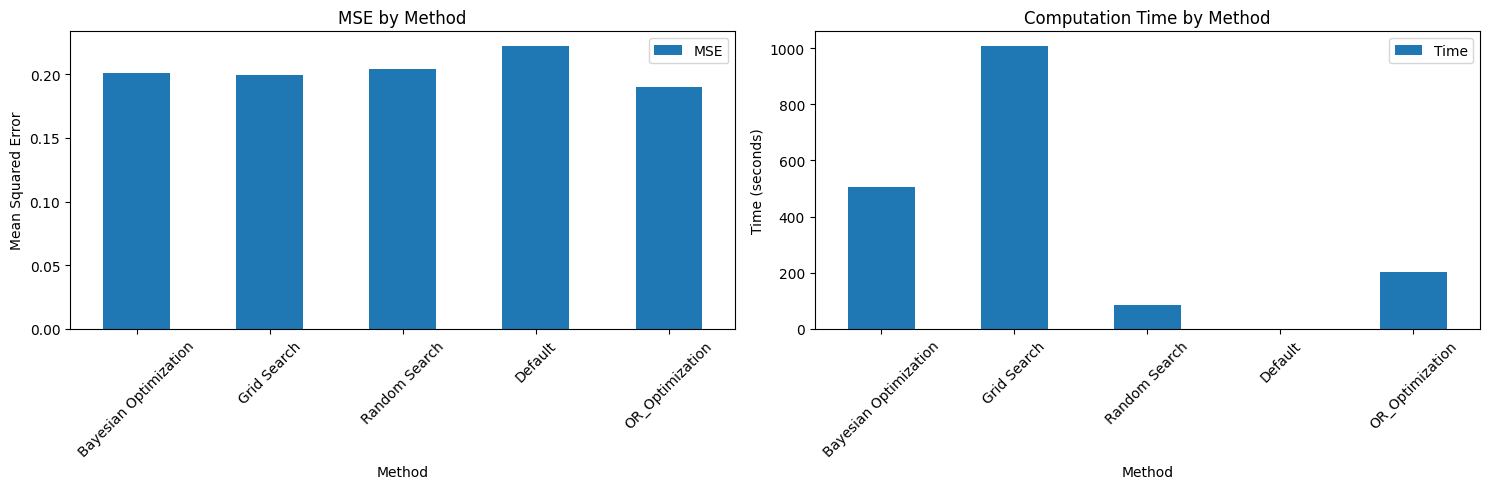

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Create dataframe for plotting
df_results = pd.DataFrame({
    'Method': list(results.keys()),
    'MSE': [r['MSE'] for r in results.values()],
    'Time': [r['Time'] for r in results.values()]
})

# Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot MSE comparison
df_results.plot(kind='bar', x='Method', y='MSE', ax=ax1)
ax1.set_title('MSE by Method')
ax1.set_ylabel('Mean Squared Error')
ax1.tick_params(axis='x', rotation=45)

# Plot time comparison
df_results.plot(kind='bar', x='Method', y='Time', ax=ax2)
ax2.set_title('Computation Time by Method')
ax2.set_ylabel('Time (seconds)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:

# save results in json file:


# Convert NumPy data types to native Python data types
def convert_to_native(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(i) for i in obj]
    else:
        return obj

# Convert results to native Python data types
results_native = convert_to_native(results)

# Save results in JSON file
with open('results.json', 'w') as f:
    json.dump(results_native, f, indent=4)

